# Autoencoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader #, ConcatDataset

import torchvision
import torch.nn.functional as F
from torchvision import transforms, datasets

## 오토인코더 정의

- 오토인코더는 레이블 되지 않은 데이터에 대한 효율적인 부호화(coding)를 학습하는 인공신경망입니다.

- 오토인코더는 입력을 부호화하는 인코더 부분과 부호화된 정보를 다시 복원하는 디코더로 구성되며 이때 부호화된 정보는 입력보다 차원이 작게 설계되기 때문에 입력을 압축하게 되고 효율적인 복원이 이뤄져야 하므로 이 압축된 코드에 유용한 정보만 남게 될 것이란 가정을 하고 있습니다.

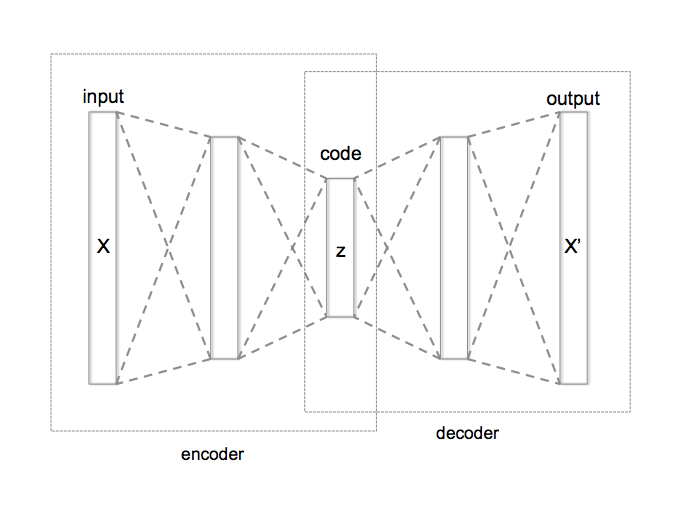

- 입력 $X$와 출력 $X'$는 동일한 차원의 벡터가 되고 이 두 벡터가 동일하게 되도록 신경망이 학습됩니다.

- 따라서 오토인코더를 학습하는 과정은 비지도학습 과정이며 보통 $X$와 $X'$가 동일하기를 바라기 때문에 두 벡터사이의 손실은 주로 MSE 를 사용하게 됩니다.

## 오토인코더를 이용한 이상치 탐지

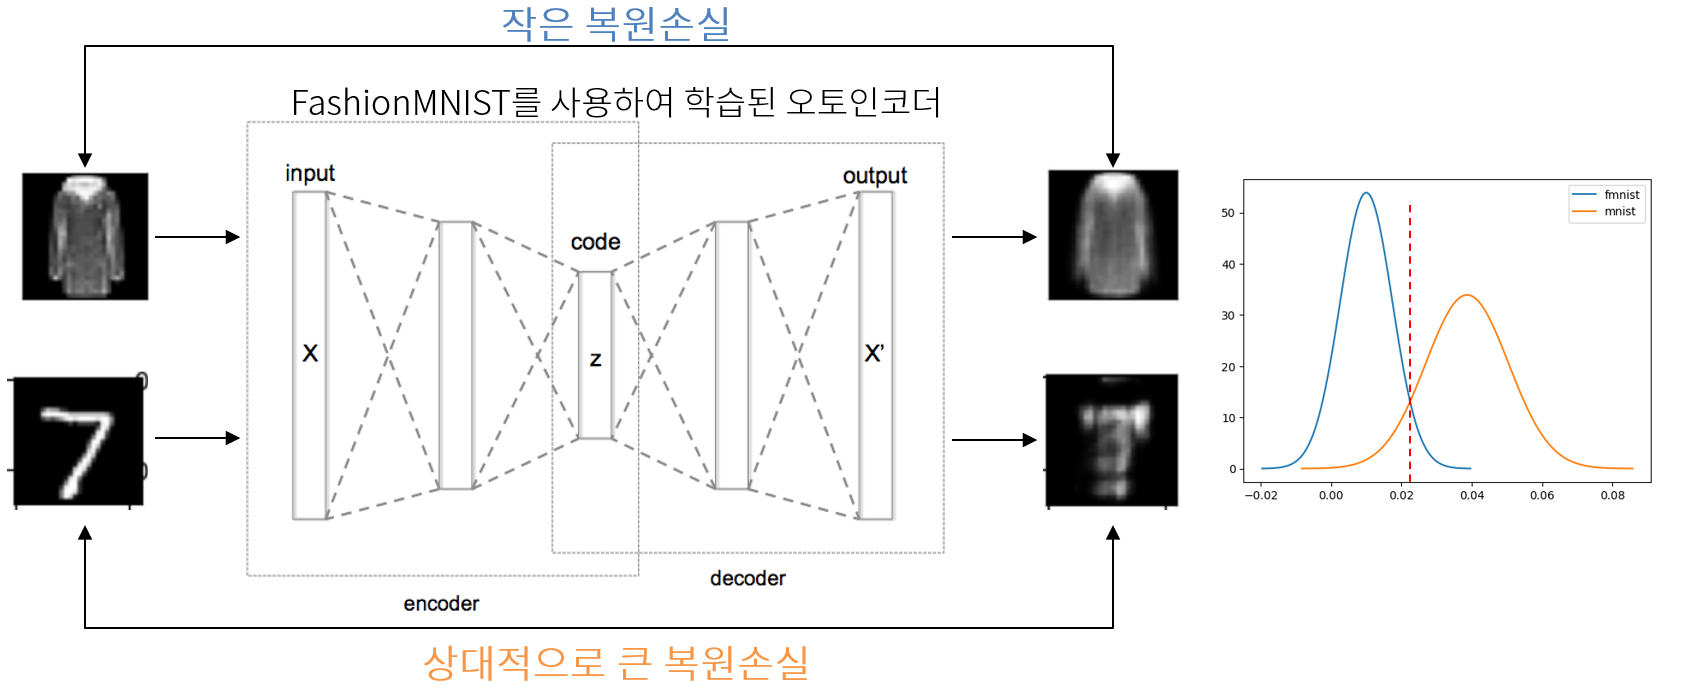

- 특정 데이터에 대해 학습한 오토인코더는 그 데이터를 잘 복원하게 됩니다. 그림의 예처럼 fashionmnist 데이터에 대해 학습한 오토인코더는 각종 의류 이미지를 잘 복원하게 됩니다.

- 이때 fashionmnist 데이터셋에 작은 수의 mnist 데이터가 포함되어 있다면 이 데이터는 이상치가 될 것입니다.

- 이 데이터를 학습된 오토인코더에 입력하면 그림처럼 제대로 복원하지 못하게 되고 복원 손실은 커지게 됩니다.

- 학습된 오토인코더가 발생시키는 복원손실값이 정규분포한다는 가정을 하면 fashionmnist에 대한 복원 손실의 분포를 위 그림에서 파란색 그래프로 그릴 수 있습니다.

- 반면 mnist에 대한 복원 손실은 주황색 그래프로 그려 집니다.

- 이 두 분포 사이에 차이가 존재하기때문에 적당한 임계값(그림에서 빨간색 세로 점선)을 잘 설정해서 이 임계값을 넘는 복원 손실을 주는 샘플을 이상치로 분류할 수 있습니다.

- 이상의 과정을 실습으로 실험해보도록 하겠습니다.

In [2]:
# 하이퍼파라미터 준비
epochs = 10
m = 64

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

- pytorch를 배울 때 사용했던 방식대로 fashionmnist 데이터를 불러옵니다.

In [3]:
D_train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform= transforms.ToTensor()
)

D_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18267581.41it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 341182.18it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6086921.17it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16296058.11it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



- 적당히 데이터로더도 준비합니다.

In [4]:
train_loader = DataLoader(D_train, batch_size=m, shuffle=True)
train_loader_iter = iter(train_loader)

test_loader = DataLoader(D_test, batch_size=1, shuffle=False)
test_loader_iter = iter(test_loader)

- 위 그림대로 내부에 인코더와 디코더를 시퀀셜 모델로 가지는 클래스 모델을 구성합니다.

In [5]:
# 오토인코더 모듈 정의
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # 입력으로 부터 더 작은 차원으로 점진적으로 진행하는
        # 인코더를 시퀀셜 모델로 정의 합니다.
        # 784 -> 128, activation: ReLU(), BatchNorm1d()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            # ...


        )

        # 인코더의 출력 크기부터 점진적으로 입력의 크기로
        # 되돌아오는 디코더를 정의 합니다.
        # 128 -> 784, activation: ReLU(), BatchNorm1d()
        self.decoder = torch.nn.Sequential(
            # ....



            torch.nn.Sigmoid()
        )

    def forward(self, x):
        # 인코더와 디코더를 순서대로 포워드 시키고
        # 두 결과를 반환합니다.
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

- 모델을 생성하고 포워드 테스트를 합니다.

In [6]:
model = AutoEncoder()

- 포워딩 결과 얻어지는 `encoded`와 `decoded`의 크기를 보고 제대로 포워딩되고 있는지 확인할 수 있습니다.

In [7]:
# forward test
mini_batch = next(train_loader_iter)

encoded, decoded = model(mini_batch[0])

encoded.shape, decoded.shape

(torch.Size([64, 784]), torch.Size([64, 784]))

- 옵티마이저와 손실함수 적당히 정의합니다.

- 손실함수는 앞서 이야기한대로 `MSELoss`를 사용합니다.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

ValueError: optimizer got an empty parameter list

- 오토인코더가 학습되면서 매 에폭 테스트할 이미지를 준비합니다.

In [ ]:
# 매 에폭마다 주입할 테스트 이미지
test_data = torch.cat([next(test_loader_iter)[0] for i in range(5)]).to(device)
test_data.shape

In [ ]:
#학습하기
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (X_batched, y_batched) in enumerate(train_loader):
        X_batched = X_batched.to(device)

        optimizer.zero_grad()
        encoded, decoded = model(X_batched)

        # (배치, 출력차원)을 다시 이미지 상태로 reshape한후
        # 손실을 계산
        decoded = decoded.reshape(-1, 1, 28, 28)
        loss = criterion(decoded, X_batched)
        loss.backward()
        optimizer.step()

        running_loss += loss

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}: {avg_loss:.5f}")

    model.eval()

    # 앞서 준비한 테스트 데이터를 입력하여 제대로 복원되는지
    # 그림으로 확인
    _, decoded = model(test_data) # (m, 784)

    fig, ax = plt.subplots(figsize=(5, 2), nrows=2, ncols=5)

    for i in range(5):
        img = test_data[i].cpu().numpy().squeeze()
        ax[0][i].imshow(img, cmap='gray')
        ax[0][i].set_xticks(())
        ax[0][i].set_yticks(())

    for i in range(5):
        img = decoded[i].detach().cpu().numpy().reshape(28,28)
        ax[1][i].imshow(img, cmap='gray')
        ax[1][i].set_xticks(())
        ax[1][i].set_yticks(())

    plt.show()

- 학습 과정을 보면 복원 손실은 지속적으로 감소하고 있으며 복원 이미지도 에폭을 반복할 수록 디테일이 살아나는 것을 확인할 수 있습니다.

- 학습 데이터에 대한 평균적인 복원 손실을 계산합니다.

In [ ]:
running_loss = 0.0

for i, (X_batched, y_batched) in enumerate(train_loader):
    X_batched = X_batched.to(device)

    with torch.no_grad():
        _, decoded = model(X_batched)

        decoded = decoded.reshape(-1, 1, 28, 28)
        loss = criterion(decoded, X_batched)
        running_loss += loss

    avg_loss = running_loss / len(train_loader)

print(avg_loss.item())

- 검증 데이터에 대한 평균적인 복원 손실을 계산합니다.

In [ ]:
# reconstruction loss for fashion-mnist
running_loss = 0.0

for i, (X_batched, y_batched) in enumerate(test_loader):
    X_batched = X_batched.to(device)

    with torch.no_grad():
        _, decoded = model(X_batched)

        decoded = decoded.reshape(-1, 1, 28, 28)
        loss = criterion(decoded, X_batched)
        running_loss += loss

    avg_loss = running_loss / len(test_loader)

print(avg_loss.item())

- 학습 데이터에 비해 약간 높은 것을 확인할 수 있고 이는 당연한 결과입니다.

- 테스트 데이터에 대한 복원손실을 모두 저장하여 평균과 표준편차를 구합니다.

In [ ]:
# reconstruction loss for fashion-mnist
fmnist_test_loss = []

for i, (X_batched, y_batched) in enumerate(test_loader):
    X_batched = X_batched.to(device)

    with torch.no_grad():
        _, decoded = model(X_batched)

        decoded = decoded.reshape(-1, 1, 28, 28)
        loss = criterion(decoded, X_batched)
        fmnist_test_loss.append(loss.detach().cpu())


In [ ]:
fmnist_test_loss = np.array(fmnist_test_loss)
fmnist_loss_mean = fmnist_test_loss.mean()
fmnist_loss_std = fmnist_test_loss.std()

In [ ]:
fmnist_loss_mean, fmnist_loss_std

- 이제 이 오토인코더를 이상치 탐지 모델로 사용하기 위해 이상치로 사용할 mnist 데이터를 불러옵니다.

In [ ]:
D_mnist_test = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=False, # True: train set, False: test set
    transform=transforms.ToTensor(),
    download=True
)

- 데이터로더를 만들고

In [ ]:
test_mnist_loader = DataLoader(D_mnist_test, batch_size=1, shuffle=False)
test_mnist_loader_iter = iter(test_mnist_loader)

- 숫자 데이터를 입력하여 복원한 이미지를 영상으로 확인해보겠습니다.

In [ ]:
# mnist에 대해서 테스트




fig, ax = plt.subplots(figsize=(2, 1), nrows=1, ncols=2)

ax[0].imshow(D_mnist_test[0][0].squeeze().numpy(), cmap='gray')
ax[1].imshow(img, cmap='gray')

plt.show()

- 예상처럼 제대로 복원하지 못하는 모습을 확인할 수 있습니다. `test_mnist_loader`를 사용하여 이상태 데이터에 대한 복원 손실 평균과 표준편차를 구합니다.

In [ ]:
# reconstruction loss for fashion-mnist
mnist_test_loss = []

for i, (X_batched, y_batched) in enumerate(test_mnist_loader):
    X_batched = X_batched.to(device)

    with torch.no_grad():
        _, decoded = model(X_batched)

        decoded = decoded.reshape(-1, 1, 28, 28)
        loss = criterion(decoded, X_batched)
        mnist_test_loss.append(loss.detach().cpu())


In [ ]:
mnist_test_loss = np.array(mnist_test_loss)
mnist_loss_mean = mnist_test_loss.mean()
mnist_loss_std = mnist_test_loss.std()

In [ ]:
mnist_loss_mean, mnist_loss_std

- 구해진 두 데이터에 대한 복원 손실의 분포를 확인해보겠습니다.

In [ ]:
import scipy.stats as stats
import math

fmnist_x = np.linspace(fmnist_loss_mean - 4*fmnist_loss_std,
                       fmnist_loss_mean + 4*fmnist_loss_std, 100)
plt.plot(fmnist_x,
    stats.norm.pdf(fmnist_x, fmnist_loss_mean, fmnist_loss_std),
    label='fmnist'
)

mnist_x = np.linspace(mnist_loss_mean - 4*mnist_loss_std,
                      mnist_loss_mean + 4*mnist_loss_std, 100)
plt.plot(mnist_x,
    stats.norm.pdf(mnist_x, mnist_loss_mean, mnist_loss_std),
    label='mnist'
)

plt.legend()

plt.show()

- 0.02 근처를 기준으로 두 분포가 겹치고 있습니다. 오토인코더가 정교해질 수록 이 두 분포는 명확하게 구분될 것입니다.

- 마지막으로 fmnist 데이터 1만개, mnist 데이터 200개 섞어 새로운 데이터 셋을 만들고 이 오토인코더가 이상치를 어떻게 탐지하는지 실험해보겟습니다.

- pytorch 데이터 셋을 pandas 데이터 프레임으로 변환하는 보조함수를 정의 합니다.

In [ ]:
def dataset_to_dataframe(dataset, label=None):
    df = pd.DataFrame(
        [dataset[i][0].numpy().reshape(-1)
            for i in range(len(dataset))],
        dtype=np.float32
    )
    df['label'] = label

    return df


- 두 데이터를  하나의 데이터 셋으로 만들기 위해 데이터셋을 위에 정의한 보조함수를 이용해 데이터프레임으로 변환합니다.

In [ ]:
fmnist_test_df = dataset_to_dataframe(D_test, 'fmnist')
mnist_test_df = dataset_to_dataframe(D_mnist_test, 'mnist')

- 변환된 데이터 프레임을 적당한 크기로 이어 붙인 다음 무작위로 섞어 세로운 데이터 프레임을 만듭니다.

In [ ]:
test_df = pd.concat([fmnist_test_df, mnist_test_df.iloc[:200]], axis=0)

In [ ]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.head()

- 생성된 데이터 프레임에는 fmnist 1만개, mnist 200개가 들어있습니다. 이상치 비율은 2%입니다.

In [ ]:
test_df['label'].value_counts()

- 레이블과 입력 피쳐로 분리합니다.

- 이 실험에서 레이블은 결과를 확인하기 위해서만 사용한다는 점을 인지해야 합니다.

- 학습 과정에서 레이블을 사용하지 않았기 때문에 이상치 탐지를 위해 확보된 데이터에 레이블이 없더라도 이 방법을 사용할 수 있습니다.

- 물론 이상치의 비율이 높다면 오토인코더가 제대로 학습되지 않기 때문에 이상치의 비율이 극도로 낮은 또는 정상 데이터만 들어있는 데이터 셋을 사용해야 합니다.

In [ ]:
y = test_df['label']
X = test_df.drop('label', axis=1).to_numpy()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # return value assignment
        image = self.X[idx].reshape(1, 28, 28)
        label = self.y[idx]

        return image, label


In [ ]:
D_cst = CustomDataset(X, y)

- 무작위로 데이터를 샘플링해서 레이블과 이미지 쌍이 잘 맞는지 확인합니다.

In [ ]:
idx = np.random.randint(0,len(D_cst))
print(D_cst[idx][1])
plt.imshow(D_cst[idx][0].reshape(28,28), cmap='gray')
plt.show()

- 데이터로더를 만들고 모든 데이터를 순차적으로 모델이 입력하고 계산되는 손실을 입계값과 비교합니다.

- 여기서 임계값은 0.022로 설정되었습니다. precision, recall을 계산하면서 가장 적당한 임계값을 설정할 필요가 있습니다.

In [ ]:
cst_loader = DataLoader(D_cst, batch_size=1, shuffle=False)

In [ ]:
# reconstruction loss for mnist
running_loss = 0.0
pred = []
truth = []

for i, (X_batched, y_batched) in enumerate(cst_loader):
    X_batched = X_batched.to(device)

    with torch.no_grad():
        _, decoded = model(X_batched)

        decoded = decoded.reshape(-1, 1, 28, 28)
        loss = criterion(decoded, X_batched)

    if loss > 0.022: #fmnist_loss_mean + 1.5*fmnist_loss_std:
        pred.append('mnist')
    else:
        pred.append('fmnist')

    truth.append(y_batched[0])


In [ ]:
df = pd.DataFrame({'truth':truth, 'pred':pred})

In [ ]:
df.head()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
confusion_matrix(df['truth'], df['pred'])

In [ ]:
print(classification_report(df['truth'], df['pred']))